In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Creating the Data

In [2]:
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y,noise=False):
        term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
        term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
        term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
        term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
        if noise==True:
            term5 = 0.2*np.random.normal(0,1,len(x))
            return term1+term2+term3+term4+term5
        else:
            return term1 + term2 + term3 + term4

z = FrankeFunction(x, y, noise=True)

## Plot of the Surface

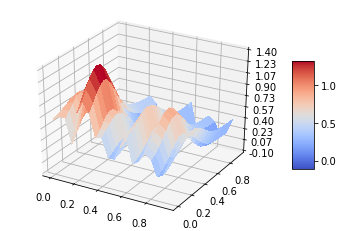

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Creating the design Matrix

In [4]:
def create_X(x, y, n ):
        if len(x.shape) > 1:
                x = np.ravel(x)
                y = np.ravel(y)

        N = len(x)
        l = int((n+1)*(n+2)/2)          # Number of elements in beta                                                               
        X = np.ones((N,l))

        for i in range(1,n+1):
                q = int((i)*(i+1)/2)
                for k in range(i+1):
                        X[:,q+k] = (x**(i-k))*(y**k)

        return X

In [5]:
def MSE(y,ypred):
    MSE = np.mean((y-ypred)**2)
    return MSE

def R2(y,ypred):
    return 1-np.sum((y-ypred)**2)/np.sum((y-np.mean(y))**2)

def Scaling(X_train, X_test):
        
        if len(X_train[0,:]) <= 1:
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        else:
            scaler = StandardScaler()
            scaler.fit(X_train[:,1:])
            X_train = scaler.transform(X_train[:,1:])
            X_test = scaler.transform(X_test[:,1:])
            
            # Adding the intercept after the scaling, as the StandardScaler removes the 1s in the first column.
            intercept_train = np.ones((len(X_train),1))
            intercept_test = np.ones((len(X_test),1))
            X_train = np.concatenate((intercept_train,X_train),axis=1)
            X_test = np.concatenate((intercept_test,X_test),axis=1)
        return X_train, X_test

def OLSreg(X_train, X_test, z_train, z_test):
        
        # Decomposing (X_train * X_train.T) to avoid singular matrix when inverting
        u, s, vt = np.linalg.svd(X_train, full_matrices=True)
        smat = np.zeros((X_train.shape))
        smat[:len(X_train[0,:]),:len(X_train[0,:])] = np.diag(s)
        XTX = vt.T.dot(smat.T.dot(smat)).dot(vt)
        
        # Estimating the Ordinary Least Squares Beta Matrix
        OLSbeta = np.linalg.inv(XTX).dot(X_train.T).dot(z_train)
        
            
        # Making the prediciton
        z_tilde = X_train @ OLSbeta
        z_predict = X_test @ OLSbeta
        
        
        # Calculating the variance
        betavariance = np.sqrt(np.diagonal(np.linalg.inv(X_train.T.dot(X_train))*np.var(z_train-z_tilde)))
        
       
        return z_tilde, z_predict, betavariance, OLSbeta


## Ordinary Least Squares on the data set

The MSE for the prediciton is:
0.006156512619006408 

The R2 for the prediciton is:
0.9235150718833659 



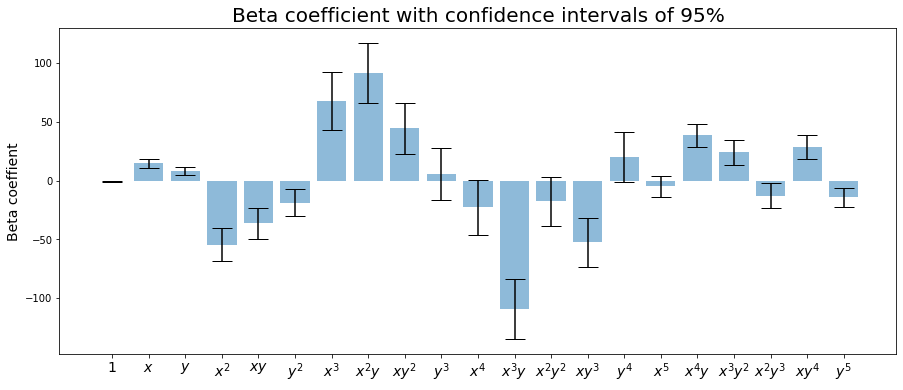

In [8]:
N = 100
x, y = np.random.uniform(0,1,size=(2,N))
z = FrankeFunction(x, y,noise=False)

n=5 # Polynomial degree
X = create_X(x,y,n)
        
# Splitting into testing and training
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)


z_tilde, z_predict, betavariance, OLSbeta = OLSreg(X_train, X_test, z_train, z_test)


"""
# Decomposing (X_train * X_train.T) to avoid singular matrix when inverting
u, s, vt = np.linalg.svd(X_train, full_matrices=True)
smat = np.zeros((X_train.shape))
smat[:len(X_train[0,:]),:len(X_train[0,:])] = np.diag(s)
XTX = vt.T.dot(smat.T.dot(smat)).dot(vt)


# Estimating the Ordinary Least Squares Beta Matrix
OLSbeta = np.linalg.inv(XTX).dot(X_train.T).dot(z_train)


# Making the prediciton
z_tilde = X_train @ OLSbeta
z_predict = X_test @ OLSbeta
"""

# Calculating the variance
betavariance = np.sqrt(np.diagonal(np.linalg.inv(X_train.T.dot(X_train))*np.var(z_train-z_tilde)))

print("The MSE for the prediciton is:")
print(MSE(z_test, z_predict), "\n")

print("The R2 for the prediciton is:")
print(R2(z_test, z_predict), "\n")


# Plotting the figure

fig, ax = plt.subplots(figsize=(15,6))

labels= ['1','$x$','$y$','$x^2$','$xy$','$y^2$','$x^3$','$x^2y$','$xy^2$','$y^3$','$x^4$',
         '$x^3y$','$x^2y^2$','$xy^3$','$y^4$','$x^5$','$x^4y$','$x^3y^2$','$x^2y^3$','$xy^4$','$y^5$']

x_pos = np.arange(len(labels))
ax.bar(x_pos, OLSbeta, 
       yerr=2*betavariance,
      alpha=0.5,
      capsize=10)
ax.set_ylabel('Beta coeffient', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=14)
ax.set_title('Beta coefficient with confidence intervals of 95%', fontsize=20)

plt.show()

## Part b): Bias-variance trade-off and resampling techniques.

In [9]:
N = 2000
x, y = np.random.uniform(0,1,size=(2,N))
z = FrankeFunction(x, y,noise=True)

# Array of polynomial degrees
n=np.arange(50)

TrainError = np.zeros(n.shape)
TestError = np.zeros(n.shape)



for i in range(len(n)):
    # Setting up the design matrix
    X = create_X(x,y,n[i])
    
    # Splitting into testing and training
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scaling the train and test set
    X_train, X_test = Scaling(X_train, X_test)

    
    # Decomposing (X_train * X_train.T) to avoid singular matrix when inverting
    u, s, vt = np.linalg.svd(X_train, full_matrices=True)
    S = np.zeros((X_train.shape))
    S[:len(X_train[0,:]),:len(X_train[0,:])] = np.diag(s)
    XTX = vt.T.dot(S.T.dot(S)).dot(vt)

    # Estimating the Ordinary Least Squares Beta Matrix
    OLSbeta = np.linalg.pinv(XTX).dot(X_train.T).dot(z_train)


    # Making the prediciton
    z_tilde = X_train @ OLSbeta
    z_predict = X_test @ OLSbeta

    
    
    
    # Computing the OLS prediction
    #z_tilde, z_predict, betavariance, OLSbeta = OLSreg(X_train, X_test, z_train, z_test)
    
    
    
    
    
    


    TrainError[i] = MSE(z_train, z_tilde)
    TestError[i] = MSE(z_test, z_predict)
    


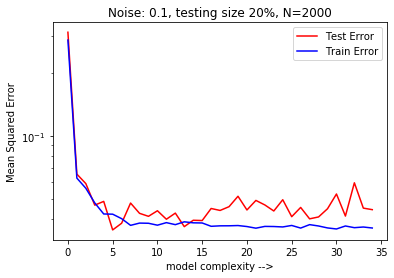

In [10]:
startpoint = 0
endpoint = 35
plt.plot(n[startpoint:endpoint],TestError[startpoint:endpoint],'r' ,label='Test Error')
plt.plot(n[startpoint:endpoint],TrainError[startpoint:endpoint],'b' ,label='Train Error')
plt.xlabel('model complexity -->')
plt.ylabel('Mean Squared Error')
plt.title("Noise: 0.1, testing size 20%, N=2000")
plt.yscale("log")
plt.legend()

## Incorporating bootstrap techniques

[2 4 3 ... 3 3 1]


In [64]:
def Resample(x,y):
    size = len(x)
    index = np.random.randint(1, size, size=size)
    x_ = x[index,:]
    y_ = y[index]
    return x_, y_

def OLSPredict(X_train, y_train):
    u, s, vt = np.linalg.svd(X_train, full_matrices=True)
    S = np.zeros((X_train.shape))
    S[:len(X_train[0,:]),:len(X_train[0,:])] = np.diag(s)
    XTX = vt.T.dot(S.T.dot(S)).dot(vt)

    # Estimating the Ordinary Least Squares Beta Matrix
    OLSbeta = np.linalg.pinv(XTX).dot(X_train.T).dot(y_train)
    return OLSbeta

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in square
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in square
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:183: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
C:\Users\Jester

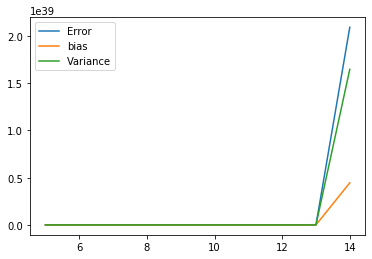

In [95]:
N = 1000
n=np.arange(15)
n_bootstraps = 100


# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
z = FrankeFunction(x, y,noise=False)

error = np.zeros(n.shape)
bias = np.zeros(n.shape)
variance = np.zeros(n.shape)

for i in range(len(n)):
    # Setting up the design matrix
    X = create_X(x,y,n[i])
    
    # Splitting into testing and training
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scaling the train and test set
    #X_train, X_test = Scaling(X_train, X_test)

    # Setting up the array for the bootstrapped predictions
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    
    for j in range(n_bootstraps):
        x_,z_ = Resample(X_train, z_train)
        OLSbeta = OLSPredict(x_,z_)   
        z_pred[:,i] = X_test @ OLSbeta 
    
    #Reshaping
    z_test = z_test.reshape(len(z_test),1)
    
    
    error[i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

plt.plot(n, error, label='Error')
plt.plot(n, bias, label='bias')
plt.plot(n, variance, label='Variance')
plt.legend()
plt.show()

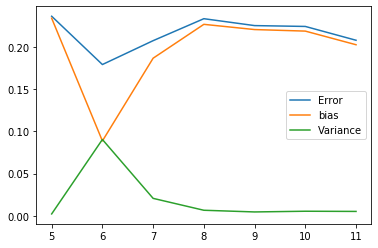

In [101]:
startpoint = 0
endpoint = 12

plt.plot(n[startpoint:endpoint], error[startpoint:endpoint], label='Error')
plt.plot(n[startpoint:endpoint], bias[startpoint:endpoint], label='bias')
plt.plot(n[startpoint:endpoint], variance[startpoint:endpoint], label='Variance')
plt.legend()
plt.show()

In [99]:
print(n)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [72]:
print(X_train.shape, x_.shape)

(160, 1) (160, 1)


In [75]:
print(z_test.shape, z_pred.shape)

(40,) (40, 50)


In [79]:
z_test - z_pred

ValueError: operands could not be broadcast together with shapes (40,) (40,50) 

In [86]:
z_train.ravel().shape

(160,)

In [83]:
np.mean((z_test.reshape(40,1) - z_pred)**2, axis=1, keepdims=True)

array([[0.07817296],
       [0.12046968],
       [0.02773658],
       [0.07075217],
       [0.06395618],
       [0.25812405],
       [0.03782035],
       [0.51206119],
       [0.05908634],
       [0.16471686],
       [0.05398232],
       [0.67382244],
       [0.03720461],
       [0.09368275],
       [0.20167882],
       [0.72291982],
       [0.0581009 ],
       [0.10871219],
       [0.08337776],
       [0.64052872],
       [0.16402122],
       [0.24863348],
       [0.06767802],
       [0.11560852],
       [0.04686436],
       [0.01944245],
       [0.1588676 ],
       [0.05575173],
       [0.05065134],
       [0.06640334],
       [0.03928856],
       [0.43275987],
       [0.03621833],
       [1.02718588],
       [0.12203639],
       [0.0952792 ],
       [0.21462946],
       [0.04058362],
       [0.12890761],
       [0.12511963]])

In [20]:
x[np.random.randint(1,5, size=len(x))]

array([2, 2, 3, 2, 2])

In [22]:
from sklearn.utils import resample


In [35]:
x= np.arange(5)
y = x**2
print("x is:", x, "\n\n","y is:", y)

x is: [0 1 2 3 4] 

 y is: [ 0  1  4  9 16]


In [36]:
x_,y_ = resample(x,y)

In [37]:
print("x_ is:", x_, "\n\n","y_ is:", y_)

x_ is: [0 2 0 2 3] 

 y_ is: [0 4 0 4 9]


In [38]:
x_,y_ = Resample(x,y)

In [39]:
print("x_ is:", x_, "\n\n","y_ is:", y_)

x_ is: [3 4 2 1 4] 

 y_ is: [ 9 16  4  1 16]


In [41]:
X_train.shape

(1600, 1275)

In [45]:
X_train[:,0].shape

(1600,)

In [48]:
size = len(X_train)
index = np.random.randint(1, size, size=size)
x_ = X_train[index]

In [50]:
x_.shape

(1600, 1275)

In [51]:
x_[0]

array([ 1.        ,  1.07877204, -0.25531807, ..., -0.15744029,
       -0.17902986, -0.20367528])

In [52]:
X_train[0]

array([ 1.        ,  0.76729586, -1.69065163, ..., -0.15744029,
       -0.17902986, -0.20367528])

In [53]:
X_train[0].shape

(1275,)

In [61]:
x_,z_ = Resample(X_train, z_train)

In [62]:
X_train[0]

array([ 1.        ,  0.76729586, -1.69065163, ..., -0.15744029,
       -0.17902986, -0.20367528])

In [63]:
x_[0]

array([ 1.        , -0.90166134, -0.14533081, ..., -0.15744029,
       -0.17902986, -0.20367528])

In [59]:
x_.shape

(1600,)